In [1]:
# --- Import Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- 1. Load Datasets ---
demographics = pd.read_csv("customer_demographics_contaminated.csv")
transactions = pd.read_csv("customer_transactions_contaminated.csv")
social = pd.read_csv("social_media_interactions_contaminated.csv")

In [3]:
# --- 2. Data Cleaning ---
# Drop duplicates
demographics = demographics.drop_duplicates()
transactions = transactions.drop_duplicates()
social = social.drop_duplicates()

# Ensure Age is numeric
if "Age" in demographics.columns:
    demographics["Age"] = pd.to_numeric(demographics["Age"], errors="coerce")

# Ensure Amount is numeric
if "Amount" in transactions.columns:
    transactions["Amount"] = pd.to_numeric(transactions["Amount"], errors="coerce")

# Handle missing values
demographics = demographics.fillna({
    "gender": "Unknown",
    "Age": demographics["Age"].median()
})

transactions = transactions.fillna({
    "Amount": transactions["Amount"].median()
})

social = social.fillna(0)

# Ensure consistent customer_id type
for df in [demographics, transactions, social]:
    df["CustomerID"] = df["CustomerID"].astype("category")


In [4]:
# --- 3. Feature Engineering ---

# Make sure Amount column exists and is numeric
transactions["Amount"] = pd.to_numeric(
    transactions["Amount"], errors="coerce"
).fillna(0)

# Aggregate transaction info per customer
transaction_features = transactions.groupby("CustomerID", observed=True).agg(
    total_spent=("Amount", "sum"),
    avg_spent=("Amount", "mean"),
    num_transactions=("Amount", "count"),
    max_transaction=("Amount", "max"),
    min_transaction=("Amount", "min"),
).reset_index()

# --- Social Features ---
# Compute engagement score only from numeric columns
social["engagement_score"] = social.drop(columns=["CustomerID"]).select_dtypes(include="number").sum(axis=1)

# Dynamically build aggregation for all numeric columns
agg_dict = {col: ("sum") for col in social.select_dtypes(include="number").columns if col != "engagement_score"}
agg_dict["engagement_score"] = "sum"

# Aggregate per customer
social_features = social.groupby("CustomerID", observed=True).agg(agg_dict).reset_index()


In [5]:
# --- 4. Merge Datasets ---

# Standardize column name for consistency before merge
for df in [demographics, transaction_features, social_features]:
    df.rename(columns={"CustomerID": "customer_id"}, inplace=True)

merged = demographics.merge(transaction_features, on="customer_id", how="inner") \
                     .merge(social_features, on="customer_id", how="inner")

# Convert all column names to lowercase for consistency
merged.columns = merged.columns.str.lower()

print("\nMerged dataset shape:", merged.shape)
print("Columns after standardization:", merged.columns.tolist())

# --- Dataset Overview: Shape ---
num_rows, num_cols = merged.shape

print("\nNumber of observations (rows):", num_rows)
print("Number of variables (columns):", num_cols)

# If you want to confirm unique customers
unique_customers = merged["customer_id"].nunique()
print("Unique customers:", unique_customers)



Merged dataset shape: (1192, 12)
Columns after standardization: ['customer_id', 'age', 'gender', 'location', 'incomelevel', 'signupdate', 'total_spent', 'avg_spent', 'num_transactions', 'max_transaction', 'min_transaction', 'engagement_score']

Number of observations (rows): 1192
Number of variables (columns): 12
Unique customers: 1181


In [6]:
# --- 5. Save Cleaned + Engineered Dataset ---
merged.to_csv("merged_cleaned_dataset.csv", index=False)
print("\n✅ Cleaned + engineered dataset saved as 'merged_cleaned_dataset.csv'")


✅ Cleaned + engineered dataset saved as 'merged_cleaned_dataset.csv'


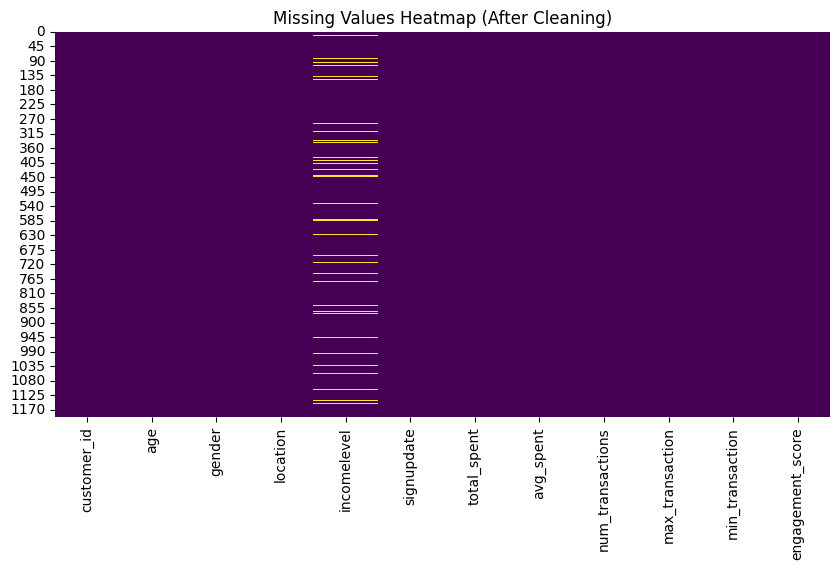

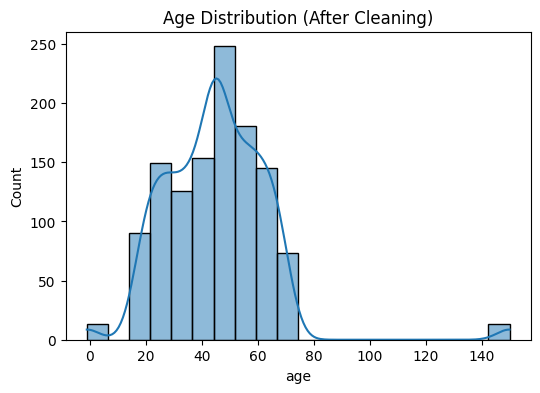

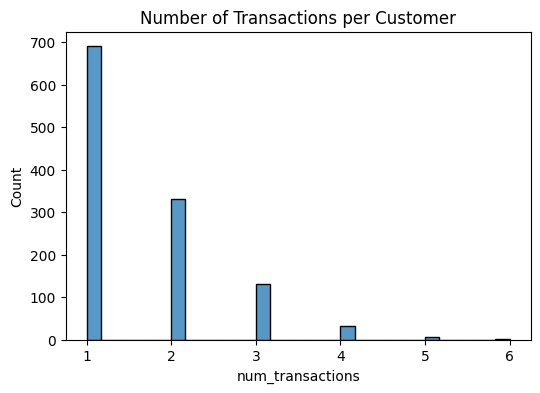

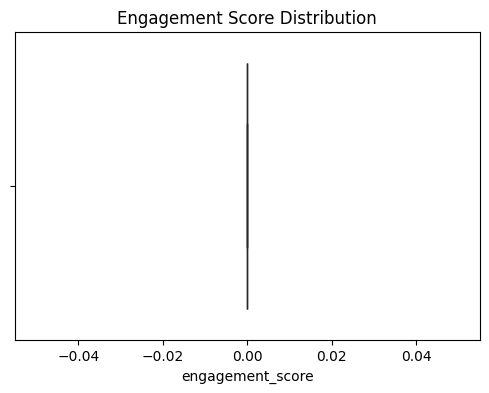

In [7]:
# --- 6. Data Quality Visualizations ---
# Missing values heatmap
plt.figure(figsize=(10,5))
sns.heatmap(merged.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (After Cleaning)")
plt.show()

# Age distribution
plt.figure(figsize=(6,4))
sns.histplot(merged["age"], bins=20, kde=True)
plt.title("Age Distribution (After Cleaning)")
plt.show()

# Transactions per customer
plt.figure(figsize=(6,4))
sns.histplot(merged["num_transactions"], bins=30, kde=False)
plt.title("Number of Transactions per Customer")
plt.show()

# Engagement score distribution
plt.figure(figsize=(6,4))
sns.boxplot(x=merged["engagement_score"], color="purple")
plt.title("Engagement Score Distribution")
plt.show()
